In [7]:
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install statsmodels

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# =========================================================
# 1 - Ler o dataset
# =========================================================
"""header=1     faz com que a linha 1 (segunda linha) contenha o nome das colunas (cabeçalho)"""
df = pd.read_excel('default_of_credit_card_clients.xls', header=1)

# Remover coluna não útil (ID)
df = df.drop(columns=['ID'])

# =========================================================
# 2 - Criar novas variáveis (feature engineering)
# =========================================================
"""
Credit_per_Age: quanto crédito o cliente possui em relação à idade; clientes muito jovens com limites altos tendem a ser mais arriscados.
BILL_MEAN: média das dívidas nos 6 meses; mostra o nível médio de endividamento.
BILL_STD: desvio padrão; mede a variação das dívidas ao longo do tempo.
BILL_TREND: diferença entre a dívida mais recente e a mais antiga; indica tendência (a dívida está crescendo ou diminuindo).
PAY_MEAN: média dos valores pagos.
PAY_STD: variação dos pagamentos.
PAY_TREND: tendência dos pagamentos (pagando mais ou menos com o tempo).
PAY_to_BILL_MEAN: proporção média do valor pago em relação à dívida média.
PAY_to_LIMIT: quanto o cliente paga, em média, em relação ao limite total.
BILL_to_LIMIT: quanto o cliente costuma dever em relação ao limite.
MAX_DELAY: maior atraso registrado.
MEAN_DELAY: atraso médio (considerando -1 como 0, porque -1 significa “pagou adiantado”).
N_DELAY: número de meses com atraso.
ANY_DELAY: 1 se o cliente atrasou em qualquer mês, 0 se nunca atrasou.
HIGH_UTILIZATION: 1 se o cliente costuma usar mais de 80% do limite.
LOW_PAYMENT_RATIO: 1 se o cliente normalmente paga menos da metade da fatura.
"""

bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
pay_cols = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
pay_status = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
df['Credit_per_Age'] = df['LIMIT_BAL'] / (df['AGE'] + 1)
df['BILL_MEAN'] = df[bill_cols].mean(axis=1)
df['BILL_STD'] = df[bill_cols].std(axis=1)
df['BILL_TREND'] = df[bill_cols].iloc[:, 0] - df[bill_cols].iloc[:, -1]
df['PAY_MEAN'] = df[pay_cols].mean(axis=1)
df['PAY_STD'] = df[pay_cols].std(axis=1)
df['PAY_TREND'] = df[pay_cols].iloc[:, 0] - df[pay_cols].iloc[:, -1]
df['PAY_to_BILL_MEAN'] = df['PAY_MEAN'] / (df['BILL_MEAN'] + 1)
df['PAY_to_LIMIT'] = df['PAY_MEAN'] / (df['LIMIT_BAL'] + 1)
df['BILL_to_LIMIT'] = df['BILL_MEAN'] / (df['LIMIT_BAL'] + 1)
df['MAX_DELAY'] = df[pay_status].max(axis=1)
df['MEAN_DELAY'] = df[pay_status].replace(-1, 0).mean(axis=1)
df['N_DELAY'] = (df[pay_status] > 0).sum(axis=1)
df['ANY_DELAY'] = (df[pay_status] > 0).any(axis=1).astype(int)
df['HIGH_UTILIZATION'] = (df['BILL_to_LIMIT'] > 0.8).astype(int)
df['LOW_PAYMENT_RATIO'] = (df['PAY_to_BILL_MEAN'] < 0.5).astype(int)

# Transforma NaN em 0. Evita que o modelo quebre ou gere erros durante o treinamento.
df = df.fillna(0)

# =========================================================
# 3 - Separar X e y.
# =========================================================
"""X contém todas as variáveis explicativas (features), enquanto que y contém a variável alvo (se o cliente é ou não inadimplente)"""
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# =========================================================
# 4 - Transformar categóricas em dummies
# =========================================================
"""Transforma variáveis categóricas em colunas numéricas binárias (One-hot encoding)
Ou seja, por exemplo, a variável categórica 'MARRIAGE' que assume três valores distintos (Solteiro, Casado e Outros) é quebrada em 3 
variáveis (MARRIAGE_SOLTEIRO, MARRIAGE_CASADO, MARRIAGE_OUTROS) que assumem valores 0 ou 1. drop_first = True evita multicolinearidade"""
X = pd.get_dummies(X, drop_first=True)

# =========================================================
# 5 - Padronizar numéricas
# =========================================================
"""Pega todas as variáveis numéricas e padroniza-as. Assim, a média de cada uma delas passa a ser 0 e o desvio padrão 1.
Com isso, todas variáveis ficam com a mesma escala e são comparáveis."""
num_cols = ['LIMIT_BAL','AGE', 'Credit_per_Age',
            'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
            'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6',
            'BILL_MEAN', 'BILL_STD', 'BILL_TREND', 'PAY_MEAN', 'PAY_STD', 'PAY_TREND',
            'PAY_to_BILL_MEAN', 'PAY_to_LIMIT', 'BILL_to_LIMIT', 'MAX_DELAY', 'MEAN_DELAY',
            'N_DELAY', 'ANY_DELAY', 'HIGH_UTILIZATION', 'LOW_PAYMENT_RATIO'
            ]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# =========================================================
# 6 - Dividir treino/teste
# =========================================================
"""
O objetivo é avaliar se o modelo aprendeu padrões reais ou apenas decorou o conjunto de treino (overfitting).
Por isso, dividimos os dados em:
    X_train, y_train -> dados usados para treinar o modelo (80%)
    X_test, y_test -> dados usados para testar o modelo (20%)
Onde o treino é usado para que o modelo 'aprenda os padrões', ou seja, ajuste seus coeficientes
e o teste é usado para avaliar o desempenho do modelo com dados nunca vistos.
random_state=42     fixa o sorteio dos dados e garante reprodutibilidade
stratify=y      garante que a proporção de inadimplentes e adimplentes seja mantida nos dois conjuntos
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

--- Regressão Logística ---
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      4673
           1       0.38      0.69      0.49      1327

    accuracy                           0.68      6000
   macro avg       0.63      0.69      0.63      6000
weighted avg       0.77      0.68      0.71      6000

AUC-ROC: 0.748


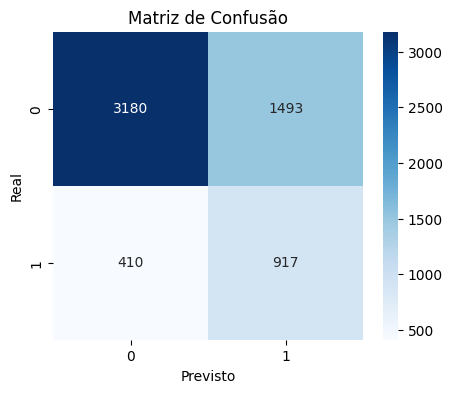

In [9]:
# =========================================================
# 7 - Balanceamento com class_weight
# =========================================================
"""
Cria-se um modelo de regressão logística
max_iter=10000   garante convergência (mais iterações para ajustar os coeficientes)
solver='lbfgs'  é o algoritmo de otimização (método numérico) usado para encontrar os melhores pesos
class_weight='balanced'     faz o modelo dar mais peso a classe minonitária (inadimplentes), compensando o desbalanceamento do dataset
fit(X_train, y_train)   ajusta os coeficientes com base no conjunto de treino.

Em resumo: o modelo aprende a relação entre as variáveis (X) e o resultado (y), penalizando mais erros da classe minoritária.
"""
logreg = LogisticRegression(max_iter=10000, solver='lbfgs', class_weight='balanced')
logreg.fit(X_train, y_train)

# =========================================================
# 8 - Ajuste de limiar de decisão
# =========================================================
"""
predict_proba    retorna as probabilidades previstas de cada cliente (do teste) ser inadimplente. A coluna [:, 1] pega apenas a probabilidade da classe inadimplente.
Por padrão, o limite de decisão é 0.5 (threshold). Entretanto, valores menores podem aumentar o 
recall (identificar mais inadimplentes), mesmo com perda de precisão.
A escolha do valor de threshold é uma decisão que deve estar alinhada com os objetivos da empresa.
"""
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.4).astype(int)

# =========================================================
# 9 - Avaliação do modelo
# =========================================================
"""
classification_report traz métricas:
    Precisão (precision) → entre os previstos como 1, quantos realmente são 1.
    Revocação (recall) → entre os reais 1, quantos o modelo acertou.
    F1-score → equilíbrio entre precisão e recall.
roc_auc_score mede a área sob a curva ROC, isto é, a capacidade do modelo de separar as classes (inadimplente e adimplente)
"""
print("--- Regressão Logística ---")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.3f}")

# Matriz de confusão. Quantos acertos e erros o modelo cometeu.
"""
(Real=0, Previsto=0) -> Cliente adimplente previsto corretamente
(Real=0, Previsto=1) -> Cliente adimplente previsto incorretamente 
(Real=1, Previsto=1) -> Cliente inadimplente previsto corretamente 
(Real=1, Previsto=0) -> Cliente inadimplente previsto incorretamente 
"""
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

Inicialmente, achei que o modelo estava pronto, porém estava esquecendo de verificar um fator crucial: se há multicolinearidade entre as variáveis.

Sem essa verificações pode ser que esteja havendo redundância entre as variáveis de modo que algumas variáveis estejam mais atrapalhando que ajudando o modelo.

E foi o que aconteceu... Ao testar algumas valores em 'app.py', percebi que o modelo estava dando um *score maior para indivíduos que mais atrasam os pagamentos*, o que é um absurdo.

Então sustentei minha hipótese e verifique se havia multicolinearidade:

In [10]:
# Pegar apenas as variáveis numéricas do dataset
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Armazenar resultados em dataframe
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) 
                   for i in range(X_numeric.shape[1])]

# Ordenar por VIF decrescente
vif_data = vif_data.sort_values(by='VIF', ascending=False)
print(vif_data)

c:\Users\ABREU\Desktop\Python\Modelo_de_Inadimplencia_e_Score\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


              Feature        VIF
16          BILL_AMT6        inf
17           PAY_AMT1        inf
18           PAY_AMT2        inf
11          BILL_AMT1        inf
12          BILL_AMT2        inf
13          BILL_AMT3        inf
14          BILL_AMT4        inf
19           PAY_AMT3        inf
20           PAY_AMT4        inf
21           PAY_AMT5        inf
22           PAY_AMT6        inf
27           PAY_MEAN        inf
29          PAY_TREND        inf
26         BILL_TREND        inf
15          BILL_AMT5        inf
24          BILL_MEAN        inf
0           LIMIT_BAL  23.565281
23     Credit_per_Age  22.556876
34         MEAN_DELAY  16.960710
33          MAX_DELAY  15.680156
36          ANY_DELAY  10.668396
1                 SEX   7.754968
28            PAY_STD   7.739193
3            MARRIAGE   6.897261
32      BILL_to_LIMIT   6.454217
35            N_DELAY   6.306630
9               PAY_5   6.122951
2           EDUCATION   5.767014
8               PAY_4   5.638933
6         

Utilizei outras formas de identificar multicolinearidade, mas o VIF foi o mais assertivo.

vif = inf => colinearidade perfeita;
vif > 10 => colineares;
vif > 5 => moderadamente colineares;

Com isso, fiz testei algumas combinações de variáveis e encontrei as que não apresentava multicolinearidade significativa. (Valores de VIF máximos estavam em 7.6 e 7.5)

--- Regressão Logística ---
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      4673
           1       0.38      0.67      0.49      1327

    accuracy                           0.68      6000
   macro avg       0.63      0.68      0.63      6000
weighted avg       0.77      0.68      0.71      6000

AUC-ROC: 0.748


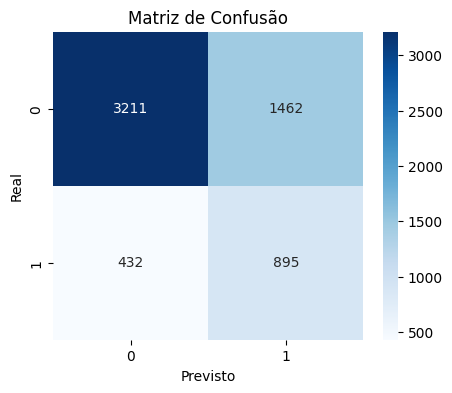

A matriz de correlação e o valor de AUC permaneceram praticamente os mesmos. Porém, a melhoria no modelo é expressiva e permite que o modelo faça sentido.

              Feature       VIF
2                 SEX  7.606895
15            PAY_STD  7.516994
14           PAY_MEAN  6.825098
4            MARRIAGE  6.688207
19      BILL_to_LIMIT  5.879921
3           EDUCATION  5.722438
9               PAY_5  4.983422
20            N_DELAY  4.691825
8               PAY_4  4.436169
12           BILL_STD  3.908411
7               PAY_3  3.773548
6               PAY_2  3.600167
10              PAY_6  3.462804
11          BILL_MEAN  3.125689
21          ANY_DELAY  2.941006
5               PAY_0  2.639831
1      Credit_per_Age  2.411858
22   HIGH_UTILIZATION  2.379861
13         BILL_TREND  2.357373
18       PAY_to_LIMIT  2.263484
23  LOW_PAYMENT_RATIO  2.009925
0                 AGE  1.272850
16          PAY_TREND  1.126680
17   PAY_to_BILL_MEAN  1.005476
Não há nenhum valor de VIF maior que 10, ou 

C:\Users\ABREU\AppData\Local\Temp\ipykernel_20712\3674573255.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


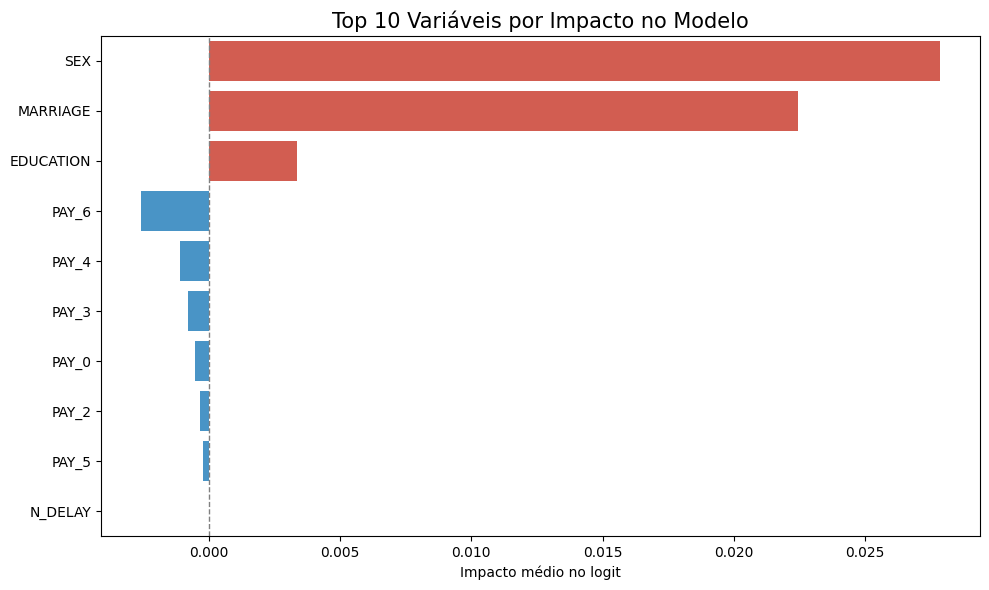

Um impacto positivo no logit aumenta a chance de inadimplência, enquanto que um impacto negativo diminui essa chance.


In [ ]:
# =========================================================
# 1 - Mesmo processo anterior, 
# porém apenas com as variáveis selecionadas
# =========================================================

# Seleção de variáveis que não apresentam multicolinearidade.
selected_features = ['AGE', 'Credit_per_Age',
                'SEX', 'EDUCATION', 'MARRIAGE',
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                'BILL_MEAN', 'BILL_STD', 'BILL_TREND', 'PAY_MEAN', 'PAY_STD', 'PAY_TREND',
                'PAY_to_BILL_MEAN', 'PAY_to_LIMIT', 'BILL_to_LIMIT',
                'N_DELAY', 'ANY_DELAY', 'HIGH_UTILIZATION', 'LOW_PAYMENT_RATIO']
# Variáveis selecionadas numéricas
selected_numerics = ['AGE', 'Credit_per_Age',
                'BILL_MEAN', 'BILL_STD', 'BILL_TREND', 'PAY_MEAN', 'PAY_STD', 'PAY_TREND',
                'PAY_to_BILL_MEAN', 'PAY_to_LIMIT', 'BILL_to_LIMIT',
                'N_DELAY', 'ANY_DELAY', 'HIGH_UTILIZATION', 'LOW_PAYMENT_RATIO']
# num_cols que será exportado deve ser igual ao modelo filtrado
num_cols = selected_numerics.copy()
# definir X e y
X_selected = df[selected_features]
y = df['default payment next month']
# dummies
X_selected = pd.get_dummies(X_selected, drop_first=True)
# padronizar
scaler = StandardScaler()
X_selected[selected_numerics] = scaler.fit_transform(X_selected[selected_numerics])
# dividir treino/teste
X_train2, X_test2, y_train, y_test2 = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
# balancear
logreg = LogisticRegression(max_iter=10000, solver='lbfgs', class_weight='balanced')
logreg.fit(X_selected, y)
# ajuste
y_pred_prob2 = logreg.predict_proba(X_test2)[:, 1]
y_pred2 = (y_pred_prob2 >= 0.4).astype(int)
# avaliação
print("--- Regressão Logística ---")
print(classification_report(y_test2, y_pred2))
print(f"AUC-ROC: {roc_auc_score(y_test2, y_pred_prob):.3f}")
# matriz de confusão
cm = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

print('A matriz de correlação e o valor de AUC permaneceram praticamente os mesmos. Porém, a melhoria no modelo é expressiva e permite que o modelo faça sentido.\n')

# =========================================================
# 2 - Sem multicolinearidade
# =========================================================

# Confirmar que as variáveis selecionadas não apresentam multicolinearidade
X_numeric = X_selected.select_dtypes(include=['float64', 'int64'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) 
                   for i in range(X_numeric.shape[1])]
vif_data = vif_data.sort_values(by='VIF', ascending=False)
print(vif_data)

print('Não há nenhum valor de VIF maior que 10, ou inf (infinito). Ou seja, as variaveis selecionadas não apresentam multicolinearidade')

# =========================================================
# 3 - Importância das variáveis
# =========================================================

# Coeficientes e contribuições médias
coefs = pd.Series(logreg.coef_[0], index=X_selected.columns)
mean_contrib = (X_selected * coefs).mean()

# Combinar num DataFrame
df_imp = pd.DataFrame({
    'Coeficiente': coefs,
    'Contribuicao_media': mean_contrib
})
df_imp['Impacto'] = df_imp['Coeficiente'] * df_imp['Contribuicao_media']

# Ordenar por impacto absoluto
df_imp = df_imp.reindex(df_imp['Impacto'].abs().sort_values(ascending=False).index)

# Selecionar top 10 variáveis por impacto absoluto
top10 = df_imp.reindex(df_imp['Impacto'].abs().sort_values(ascending=False).index).head(10)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Impacto', 
    y=top10.index, 
    data=top10,
    palette=['#E74C3C' if x > 0 else '#3498DB' for x in top10['Impacto']]
)

plt.title('Top 10 Variáveis por Impacto no Modelo', fontsize=15)
plt.xlabel('Impacto médio no logit')
plt.ylabel('')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print('Um impacto positivo no logit aumenta a chance de inadimplência, enquanto que um impacto negativo diminui essa chance.')

Para permitir exportação, salvar: modelo, scaler, colunas numericas e colunas totais

In [12]:
# Salvar modelo de regressão logística
with open('modelos/modelo_credito.pkl', 'wb') as f:
    pickle.dump(logreg, f)

# Salvar o StandardScaler
with open('modelos/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Salvar lista de colunas numéricas usadas no scaler
with open('modelos/num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f)

# Salvar lista final de colunas do modelo (após get_dummies)
cols_modelo = X_selected.columns.tolist()
with open('modelos/cols_modelo.pkl', 'wb') as f:
    pickle.dump(cols_modelo, f)